In [1]:
# Requirements
# Comment if already satisfied
#!pip install -U jupyter
#!pip install datasets transformers accelerate torch torchinfo xlrd seaborn sklearn torchmetrics
#!pip install --upgrade --quiet jupyter_client ipywidgets
#!jupyter nbextension enable --py widgetsnbextension

In [1]:
import os
import pandas as pd

DATA_DIR = "../data/"
LM_DIR = "./out/language_model"
OUT_DIR = "./out/classification_model"

os.makedirs(OUT_DIR, exist_ok=True)

SEED = 42

In [2]:
import matplotlib.pyplot as plt
def plot_training_history(train_history, val_history, model_name, phase_name, out_dir):
    fig, (loss_ax, acc_ax) = plt.subplots(figsize=(12, 8), nrows=2)
    fig.suptitle(f"{model_name} - {phase_name} History")
    loss_ax.set_title("Cross Entropy Loss")
    loss_ax.plot(train_history["loss"], label="train")
    loss_ax.plot(val_history["loss"], label="val")
    loss_ax.legend(loc="best")

    acc_ax.set_title("Classification accuracy")
    acc_ax.plot(train_history["accuracy"], label="train")
    acc_ax.plot(val_history["accuracy"], label="val")
    loss_ax.legend(loc="best")

    plt.tight_layout()

    fig.savefig(f"{out_dir}/{model_name}_{phase_name}_history.png", dpi=150, bbox_inches='tight')

    return fig

# Load Dataset

In [3]:
#articles = pd.read_excel(os.path.join(DATA_DIR, "OpArticles_ADUs.xlsx"))
adus = pd.read_csv(os.path.join(DATA_DIR, "OpArticles_ADUs.csv")) # If pandas version doesn't support .xlsx, use this instaed

adus.head()

,article_id,annotator,node,ranges,tokens,label
0,5d04a31b896a7fea069ef06f,A,0,"[[2516, 2556]]",O facto não é apenas fruto da ignorância,Value
1,5d04a31b896a7fea069ef06f,A,1,"[[2568, 2806]]",havia no seu humor mais jornalismo (mais inves...,Value
2,5d04a31b896a7fea069ef06f,A,3,"[[3169, 3190]]",É tudo cómico na FIFA,Value
3,5d04a31b896a7fea069ef06f,A,4,"[[3198, 3285]]",o que todos nós permitimos que esta organizaçã...,Value
4,5d04a31b896a7fea069ef06f,A,6,"[[4257, 4296]]",não nos fazem rir à custa dos poderosos,Value


Label Ratios
Value       0.483904
Fact        0.218778
Value(-)    0.173207
Value(+)    0.084274
Policy      0.039838
Name: label, dtype: float64


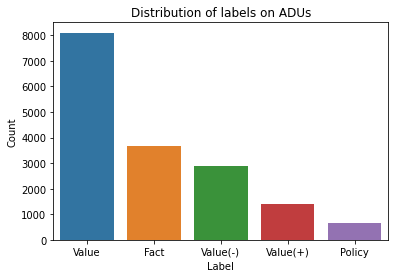

<Figure size 432x288 with 0 Axes>

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns

print("Label Ratios")
print(adus["label"].value_counts() / len(adus["label"]))

fig, ax = plt.subplots()
sns.countplot(data=adus, x="label", ax=ax)
ax.set_title("Distribution of labels on ADUs")
ax.set_xlabel("Label")
ax.set_ylabel("Count")
fig.savefig(f"{OUT_DIR}/label_distribution_full.png", dpi=150, bbox_inches='tight')
plt.show()
plt.clf()

Encode Labels

In [5]:
classes = ["Fact", "Policy", "Value", "Value(+)", "Value(-)"]
N_CLASSES = len(classes)
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
adus["label"] = le.fit_transform(adus["label"])

adus.head()

,article_id,annotator,node,ranges,tokens,label
0,5d04a31b896a7fea069ef06f,A,0,"[[2516, 2556]]",O facto não é apenas fruto da ignorância,2
1,5d04a31b896a7fea069ef06f,A,1,"[[2568, 2806]]",havia no seu humor mais jornalismo (mais inves...,2
2,5d04a31b896a7fea069ef06f,A,3,"[[3169, 3190]]",É tudo cómico na FIFA,2
3,5d04a31b896a7fea069ef06f,A,4,"[[3198, 3285]]",o que todos nós permitimos que esta organizaçã...,2
4,5d04a31b896a7fea069ef06f,A,6,"[[4257, 4296]]",não nos fazem rir à custa dos poderosos,2


# Create Train, Validation and Test splits

Train Label Ratios
Value       0.483949
Fact        0.218738
Value(-)    0.173199
Value(+)    0.084267
Policy      0.039847
dtype: float64
Validation Label Ratios
Value       0.483763
Fact        0.218738
Value(-)    0.173199
Value(+)    0.084360
Policy      0.039940
dtype: float64
Test Label Ratios
Value       0.483871
Fact        0.218937
Value(-)    0.173238
Value(+)    0.084229
Policy      0.039725
dtype: float64


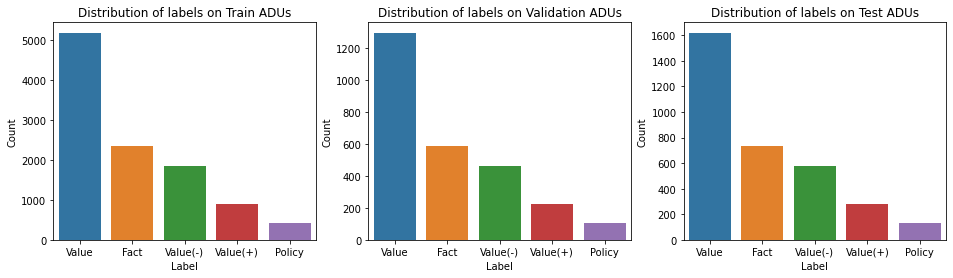

<Figure size 432x288 with 0 Axes>

In [6]:
# Maintain the ratios of labels across splits
train_val_adus = adus.groupby("label").sample(frac=0.8, random_state=SEED)
test_adus = adus.loc[adus.index.difference(train_val_adus.index)]

train_adus = train_val_adus.groupby("label").sample(frac=0.8, random_state=SEED)
val_adus = train_val_adus.loc[train_val_adus.index.difference(train_adus.index)]

fig, (train_ax, val_ax, test_ax) = plt.subplots(figsize=(16, 4), ncols=3)
for split, df, ax in zip(["Train", "Validation", "Test"], [train_adus, val_adus, test_adus], [train_ax, val_ax, test_ax]):
    df_labels = le.inverse_transform(df["label"])
    sns.countplot(x=df_labels, ax=ax, order=["Value", "Fact", "Value(-)", "Value(+)", "Policy"])
    ax.set_title(f"Distribution of labels on {split} ADUs")
    ax.set_xlabel("Label")
    ax.set_ylabel("Count")
    
    print(f"{split} Label Ratios")
    print(pd.Series(df_labels).value_counts() / len(df_labels))
fig.savefig(f"{OUT_DIR}/label_distribution_splits.png", dpi=150, bbox_inches='tight')
plt.show()
plt.clf()

In [7]:
train_adus.reset_index(inplace=True)
val_adus.reset_index(inplace=True)
test_adus.reset_index(inplace=True)

train_adus

,index,article_id,annotator,node,ranges,tokens,label
0,10106,5cf46103896a7fea06ff85a8,D,1,"[[4120, 4292]]","Erradicar o mal pela raiz, depurando a nação i...",0
1,15332,5cdd9733896a7fea062d6f9f,B,3,"[[533, 671]]",estamos neste momento face a projetos-lei na A...,0
2,14349,5cf45b79896a7fea06ff290a,D,7,"[[1925, 2056]]","são poucos os exemplos, em Portugal, de redes ...",0
3,747,5d04be1c896a7fea06a07c4b,A,31,"[[1841, 1982]]",para quase oito em cada dez portugueses que no...,0
4,2594,5cf478d6896a7fea0600d8ba,A,30,"[[834, 859]]",vitórias na época regular,0
...,...,...,...,...,...,...,...
10711,15909,5ce8e7f4896a7fea06969d15,B,0,"[[77, 111]]",Por uma lei desfasada da realidade,4
10712,262,5d04ad52896a7fea069f9c0d,A,6,"[[1127, 1189]]",este tipo de investimentos prejudicam os clube...,4
10713,3874,5cf47246896a7fea060086ea,D,4,"[[1844, 1954]]",grande aumento dos riscos de doenças tão terrí...,4
10714,5397,5cf46bc3896a7fea0600247f,C,15,"[[5598, 5673]]",a ideia de um “Museu das Descobertas” me pareç...,4


# Convert Dataset to HF Dataset

In [8]:
from datasets.dataset_dict import DatasetDict
from datasets import Dataset, DatasetInfo, Features, Value, ClassLabel
info = DatasetInfo(
    features=Features({
        "index": Value("int64"),
        "tokens": Value("string"),
        "label": ClassLabel(num_classes=N_CLASSES, names=le.classes_.tolist()),
        "article_id": Value("string"),
        "annotator": Value("string"),
        "node": Value("int64"),
        "ranges": Value("string"),
    })
)

adus_dataset = DatasetDict({
    "train": Dataset.from_pandas(train_adus, preserve_index=True, info=info),
    "val": Dataset.from_pandas(val_adus, preserve_index=True, info=info),
    "test": Dataset.from_pandas(test_adus, preserve_index=True, info=info)
})

print(adus_dataset)

DatasetDict({
    train: Dataset({
        features: ['index', 'tokens', 'label', 'article_id', 'annotator', 'node', 'ranges'],
        num_rows: 10716
    })
    val: Dataset({
        features: ['index', 'tokens', 'label', 'article_id', 'annotator', 'node', 'ranges'],
        num_rows: 2679
    })
    test: Dataset({
        features: ['index', 'tokens', 'label', 'article_id', 'annotator', 'node', 'ranges'],
        num_rows: 3348
    })
})


In [9]:
adus_dataset["train"].features

{'index': Value(dtype='int64', id=None),
 'tokens': Value(dtype='string', id=None),
 'label': ClassLabel(num_classes=5, names=['Fact', 'Policy', 'Value', 'Value(+)', 'Value(-)'], id=None),
 'article_id': Value(dtype='string', id=None),
 'annotator': Value(dtype='string', id=None),
 'node': Value(dtype='int64', id=None),
 'ranges': Value(dtype='string', id=None)}

Remove unnecessary columns

In [10]:
adus_dataset = adus_dataset.remove_columns(["annotator", "node", "ranges"])
print(adus_dataset)

DatasetDict({
    train: Dataset({
        features: ['index', 'tokens', 'label', 'article_id'],
        num_rows: 10716
    })
    val: Dataset({
        features: ['index', 'tokens', 'label', 'article_id'],
        num_rows: 2679
    })
    test: Dataset({
        features: ['index', 'tokens', 'label', 'article_id'],
        num_rows: 3348
    })
})


Base Tokenizer

In [11]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained('neuralmind/bert-large-portuguese-cased', do_lower_case=True)

In [12]:
def tokenize(batch):
    result = tokenizer(batch["tokens"])
    return result

In [13]:
cls_dataset = adus_dataset.map(
    tokenize, batched=True, remove_columns=["article_id", "tokens"]
)

print(cls_dataset)

  0%|          | 0/11 [00:00<?, ?ba/s]

  0%|          | 0/3 [00:00<?, ?ba/s]

  0%|          | 0/4 [00:00<?, ?ba/s]

DatasetDict({
    train: Dataset({
        features: ['index', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 10716
    })
    val: Dataset({
        features: ['index', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 2679
    })
    test: Dataset({
        features: ['index', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 3348
    })
})


# Define Dataloaders

In [14]:
from transformers import DataCollatorWithPadding
from torch.utils.data import DataLoader

data_collator = DataCollatorWithPadding(tokenizer=tokenizer, return_tensors="pt")

BATCH_SIZE = 64 # Tested with NVIDIA Tesla T4 16GB
train_dataloader = DataLoader(
    dataset=cls_dataset["train"],
    shuffle=True,
    batch_size=BATCH_SIZE,
    collate_fn=data_collator
)

val_dataloader = DataLoader(
    dataset=cls_dataset["val"],
    shuffle=True,
    batch_size=BATCH_SIZE,
    collate_fn=data_collator
)

test_dataloader = DataLoader(
    dataset=cls_dataset["test"],
    shuffle=False,
    batch_size=1,
    collate_fn=data_collator
)

# Model Definition

In [15]:
from transformers import AutoModelForSequenceClassification
from torchinfo import summary

model = AutoModelForSequenceClassification.from_pretrained(f"{LM_DIR}/best", num_labels=N_CLASSES)

summary(model)

Some weights of the model checkpoint at ./out/language_model/best were not used when initializing BertForSequenceClassification: ['cls.predictions.decoder.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at ./out/language_mode

Layer (type:depth-idx)                                  Param #
BertForSequenceClassification                           --
├─BertModel: 1-1                                        --
│    └─BertEmbeddings: 2-1                              --
│    │    └─Embedding: 3-1                              30,509,056
│    │    └─Embedding: 3-2                              524,288
│    │    └─Embedding: 3-3                              2,048
│    │    └─LayerNorm: 3-4                              2,048
│    │    └─Dropout: 3-5                                --
│    └─BertEncoder: 2-2                                 --
│    │    └─ModuleList: 3-6                             302,309,376
│    └─BertPooler: 2-3                                  --
│    │    └─Linear: 3-7                                 1,049,600
│    │    └─Tanh: 3-8                                   --
├─Dropout: 1-2                                          --
├─Linear: 1-3                                           5,125
Total params:

# Define Optimizer

In [16]:
from torch import optim

optimizer = optim.Adam(
    params=model.parameters(),
    lr=5e-3,
    betas=(0.9, 0.999),
    weight_decay=1e-4,
    amsgrad=True
)

# Prepare Classification Model

In [17]:
from accelerate import Accelerator

accelerator = Accelerator()

model, optimizer, train_dataloader, val_dataloader = accelerator.prepare(
    model, optimizer, train_dataloader, val_dataloader
)

/usr/local/lib/python3.6/dist-packages/setuptools/distutils_patch.py:26: UserWarning: Distutils was imported before Setuptools. This usage is discouraged and may exhibit undesirable behaviors or errors. Please use Setuptools' objects directly or at least import Setuptools first.
  "Distutils was imported before Setuptools. This usage is discouraged "


# Define Epoch Iteration

In [18]:
import torch
import torch.nn.functional as F
from tqdm import tqdm
import numpy as np

def epoch_iter(dataloader, model, is_train = True, optimizer=None, lr_scheduler=None):
    if is_train:
        assert optimizer is not None, "When training, please provide an optimizer."
      
    num_batches = len(dataloader)

    if is_train:
        model.train()
    else:
        model.eval()

    total_loss = 0.0
    probs = []
    preds = []
    expected_labels = []
    aduIds = []
    
    scaler = torch.cuda.amp.GradScaler()

    with torch.set_grad_enabled(is_train):
        for batch in tqdm(dataloader):
            index = batch.pop("index")
            
            with torch.cuda.amp.autocast():
                outputs = model(**batch)
            loss = outputs.loss

            if is_train:
                optimizer.zero_grad()
                accelerator.backward(scaler.scale(loss))
                scaler.step(optimizer)
                scaler.update()
            
            total_loss += loss.item()

            prob = F.softmax(outputs.logits, dim=1)
            final_pred = torch.argmax(prob, dim=1)

            aduIds.extend(index.detach().cpu().numpy())
            probs.extend(prob.detach().cpu().numpy())
            preds.extend(final_pred.detach().cpu().numpy())
            expected_labels.extend(batch["labels"].detach().cpu().numpy())
            
        if is_train and lr_scheduler is not None:
            lr_scheduler.step()
        
    return (expected_labels, preds, probs, aduIds), total_loss / num_batches
            

# Train Classification Model

In [19]:
from torch import optim
import torchmetrics

NUM_EPOCHS = 30

lr_scheduler = optim.lr_scheduler.ExponentialLR(
    optimizer=optimizer,
    gamma=0.9,
    verbose=True
)

metric_scorer = torchmetrics.Accuracy(
    threshold=0.5,
    num_classes=N_CLASSES,
    average="micro",
)

Adjusting learning rate of group 0 to 5.0000e-03.


In [20]:
train_history = {
    "loss": [],
    "accuracy": []
}

val_history = {
    "loss": [],
    "accuracy": []
}

model.bert.requires_grad_(False) # Freeze language model layer

best_loss = np.inf
best_accuracy = 0
best_epoch = -1

print(f"Starting classification language model training...")

for epoch in range(1, NUM_EPOCHS + 1):
    print(f"Epoch[{epoch}/{NUM_EPOCHS}]")
    
    (train_target, train_preds, train_probs, _), train_loss = epoch_iter(
        dataloader=train_dataloader,
        model=model,
        is_train=True,
        optimizer=optimizer,
        lr_scheduler=lr_scheduler
    )
    
    train_accuracy = metric_scorer(torch.tensor(np.array(train_probs)), torch.tensor(np.array(train_target))).item()
    print(f"Training loss: {train_loss:.3f}\t Training micro accuracy: {train_accuracy:.3f}")

    (val_target, val_preds, val_probs, _), val_loss = epoch_iter(
        dataloader=val_dataloader,
        model=model,
        is_train=False,
    )

    val_accuracy = metric_scorer(torch.tensor(np.array(val_probs)), torch.tensor(np.array(val_target))).item()
    print(f"Validation loss: {val_loss:.3f}\t Validation micro accuracy: {val_accuracy:.3f}")
    
    # Save best model
    if val_loss < best_loss:
        best_loss = val_loss
        best_accuracy = val_accuracy
        best_epoch = epoch
        
        accelerator.wait_for_everyone()
        unwrapped_model = accelerator.unwrap_model(model)
        unwrapped_model.save_pretrained(f"{OUT_DIR}/best", save_function=accelerator.save)

    accelerator.wait_for_everyone()
    unwrapped_model = accelerator.unwrap_model(model)
    unwrapped_model.save_pretrained(f"{OUT_DIR}/latest", save_function=accelerator.save)

    train_history["loss"].append(train_loss)
    train_history["accuracy"].append(train_accuracy)

    val_history["loss"].append(val_loss)
    val_history["accuracy"].append(val_accuracy)

    print("----------------------------------------------------------------")
    
print(
    f"\nFinished training..."
    f"\nBest epoch: {best_epoch}\t Validation loss on best epoch: {best_loss}\t Accuracy on best epoch: {best_accuracy}"
)

Starting classification language model training...
Epoch[1/30]


100%|██████████| 168/168 [00:43<00:00,  3.83it/s]


Adjusting learning rate of group 0 to 4.5000e-03.
Training loss: 1.223	 Training micro accuracy: 0.509


100%|██████████| 42/42 [00:10<00:00,  4.06it/s]


Validation loss: 1.081	 Validation micro accuracy: 0.564
----------------------------------------------------------------
Epoch[2/30]


100%|██████████| 168/168 [00:45<00:00,  3.68it/s]


Adjusting learning rate of group 0 to 4.0500e-03.
Training loss: 1.144	 Training micro accuracy: 0.535


100%|██████████| 42/42 [00:11<00:00,  3.66it/s]


Validation loss: 1.078	 Validation micro accuracy: 0.564
----------------------------------------------------------------
Epoch[3/30]


100%|██████████| 168/168 [00:48<00:00,  3.46it/s]


Adjusting learning rate of group 0 to 3.6450e-03.
Training loss: 1.123	 Training micro accuracy: 0.537


100%|██████████| 42/42 [00:12<00:00,  3.46it/s]


Validation loss: 1.120	 Validation micro accuracy: 0.532
----------------------------------------------------------------
Epoch[4/30]


100%|██████████| 168/168 [00:49<00:00,  3.41it/s]


Adjusting learning rate of group 0 to 3.2805e-03.
Training loss: 1.113	 Training micro accuracy: 0.543


100%|██████████| 42/42 [00:11<00:00,  3.65it/s]


Validation loss: 1.090	 Validation micro accuracy: 0.556
----------------------------------------------------------------
Epoch[5/30]


100%|██████████| 168/168 [00:49<00:00,  3.36it/s]


Adjusting learning rate of group 0 to 2.9525e-03.
Training loss: 1.097	 Training micro accuracy: 0.553


100%|██████████| 42/42 [00:12<00:00,  3.49it/s]


Validation loss: 1.055	 Validation micro accuracy: 0.563
----------------------------------------------------------------
Epoch[6/30]


100%|██████████| 168/168 [00:49<00:00,  3.38it/s]


Adjusting learning rate of group 0 to 2.6572e-03.
Training loss: 1.100	 Training micro accuracy: 0.546


100%|██████████| 42/42 [00:11<00:00,  3.56it/s]


Validation loss: 1.052	 Validation micro accuracy: 0.576
----------------------------------------------------------------
Epoch[7/30]


100%|██████████| 168/168 [00:48<00:00,  3.45it/s]


Adjusting learning rate of group 0 to 2.3915e-03.
Training loss: 1.087	 Training micro accuracy: 0.553


100%|██████████| 42/42 [00:11<00:00,  3.66it/s]


Validation loss: 1.061	 Validation micro accuracy: 0.569
----------------------------------------------------------------
Epoch[8/30]


100%|██████████| 168/168 [00:49<00:00,  3.43it/s]


Adjusting learning rate of group 0 to 2.1523e-03.
Training loss: 1.082	 Training micro accuracy: 0.558


100%|██████████| 42/42 [00:11<00:00,  3.67it/s]


Validation loss: 1.032	 Validation micro accuracy: 0.580
----------------------------------------------------------------
Epoch[9/30]


100%|██████████| 168/168 [00:49<00:00,  3.38it/s]


Adjusting learning rate of group 0 to 1.9371e-03.
Training loss: 1.080	 Training micro accuracy: 0.553


100%|██████████| 42/42 [00:11<00:00,  3.66it/s]


Validation loss: 1.045	 Validation micro accuracy: 0.570
----------------------------------------------------------------
Epoch[10/30]


100%|██████████| 168/168 [00:49<00:00,  3.36it/s]


Adjusting learning rate of group 0 to 1.7434e-03.
Training loss: 1.072	 Training micro accuracy: 0.559


100%|██████████| 42/42 [00:11<00:00,  3.57it/s]


Validation loss: 1.036	 Validation micro accuracy: 0.577
----------------------------------------------------------------
Epoch[11/30]


100%|██████████| 168/168 [00:48<00:00,  3.45it/s]


Adjusting learning rate of group 0 to 1.5691e-03.
Training loss: 1.073	 Training micro accuracy: 0.547


100%|██████████| 42/42 [00:11<00:00,  3.63it/s]


Validation loss: 1.027	 Validation micro accuracy: 0.578
----------------------------------------------------------------
Epoch[12/30]


100%|██████████| 168/168 [00:49<00:00,  3.40it/s]


Adjusting learning rate of group 0 to 1.4121e-03.
Training loss: 1.056	 Training micro accuracy: 0.561


100%|██████████| 42/42 [00:11<00:00,  3.64it/s]


Validation loss: 1.056	 Validation micro accuracy: 0.553
----------------------------------------------------------------
Epoch[13/30]


100%|██████████| 168/168 [00:48<00:00,  3.43it/s]


Adjusting learning rate of group 0 to 1.2709e-03.
Training loss: 1.052	 Training micro accuracy: 0.569


100%|██████████| 42/42 [00:11<00:00,  3.62it/s]


Validation loss: 1.032	 Validation micro accuracy: 0.574
----------------------------------------------------------------
Epoch[14/30]


100%|██████████| 168/168 [00:49<00:00,  3.42it/s]


Adjusting learning rate of group 0 to 1.1438e-03.
Training loss: 1.055	 Training micro accuracy: 0.570


100%|██████████| 42/42 [00:11<00:00,  3.59it/s]


Validation loss: 1.031	 Validation micro accuracy: 0.582
----------------------------------------------------------------
Epoch[15/30]


100%|██████████| 168/168 [00:48<00:00,  3.45it/s]


Adjusting learning rate of group 0 to 1.0295e-03.
Training loss: 1.057	 Training micro accuracy: 0.562


100%|██████████| 42/42 [00:11<00:00,  3.64it/s]


Validation loss: 1.019	 Validation micro accuracy: 0.582
----------------------------------------------------------------
Epoch[16/30]


100%|██████████| 168/168 [00:49<00:00,  3.39it/s]


Adjusting learning rate of group 0 to 9.2651e-04.
Training loss: 1.061	 Training micro accuracy: 0.561


100%|██████████| 42/42 [00:11<00:00,  3.54it/s]


Validation loss: 1.020	 Validation micro accuracy: 0.582
----------------------------------------------------------------
Epoch[17/30]


100%|██████████| 168/168 [00:49<00:00,  3.36it/s]


Adjusting learning rate of group 0 to 8.3386e-04.
Training loss: 1.046	 Training micro accuracy: 0.572


100%|██████████| 42/42 [00:11<00:00,  3.54it/s]


Validation loss: 1.020	 Validation micro accuracy: 0.583
----------------------------------------------------------------
Epoch[18/30]


100%|██████████| 168/168 [00:49<00:00,  3.42it/s]


Adjusting learning rate of group 0 to 7.5047e-04.
Training loss: 1.043	 Training micro accuracy: 0.571


100%|██████████| 42/42 [00:11<00:00,  3.57it/s]


Validation loss: 1.019	 Validation micro accuracy: 0.577
----------------------------------------------------------------
Epoch[19/30]


100%|██████████| 168/168 [00:49<00:00,  3.38it/s]


Adjusting learning rate of group 0 to 6.7543e-04.
Training loss: 1.052	 Training micro accuracy: 0.561


100%|██████████| 42/42 [00:11<00:00,  3.53it/s]


Validation loss: 1.017	 Validation micro accuracy: 0.583
----------------------------------------------------------------
Epoch[20/30]


100%|██████████| 168/168 [00:50<00:00,  3.34it/s]


Adjusting learning rate of group 0 to 6.0788e-04.
Training loss: 1.048	 Training micro accuracy: 0.565


100%|██████████| 42/42 [00:11<00:00,  3.55it/s]


Validation loss: 1.018	 Validation micro accuracy: 0.579
----------------------------------------------------------------
Epoch[21/30]


100%|██████████| 168/168 [00:48<00:00,  3.45it/s]


Adjusting learning rate of group 0 to 5.4709e-04.
Training loss: 1.042	 Training micro accuracy: 0.569


100%|██████████| 42/42 [00:11<00:00,  3.53it/s]


Validation loss: 1.014	 Validation micro accuracy: 0.588
----------------------------------------------------------------
Epoch[22/30]


100%|██████████| 168/168 [00:48<00:00,  3.44it/s]


Adjusting learning rate of group 0 to 4.9239e-04.
Training loss: 1.044	 Training micro accuracy: 0.568


100%|██████████| 42/42 [00:11<00:00,  3.53it/s]


Validation loss: 1.015	 Validation micro accuracy: 0.579
----------------------------------------------------------------
Epoch[23/30]


100%|██████████| 168/168 [00:49<00:00,  3.39it/s]


Adjusting learning rate of group 0 to 4.4315e-04.
Training loss: 1.034	 Training micro accuracy: 0.578


100%|██████████| 42/42 [00:11<00:00,  3.73it/s]


Validation loss: 1.015	 Validation micro accuracy: 0.584
----------------------------------------------------------------
Epoch[24/30]


100%|██████████| 168/168 [00:49<00:00,  3.38it/s]


Adjusting learning rate of group 0 to 3.9883e-04.
Training loss: 1.043	 Training micro accuracy: 0.574


100%|██████████| 42/42 [00:11<00:00,  3.61it/s]


Validation loss: 1.018	 Validation micro accuracy: 0.574
----------------------------------------------------------------
Epoch[25/30]


100%|██████████| 168/168 [00:48<00:00,  3.43it/s]


Adjusting learning rate of group 0 to 3.5895e-04.
Training loss: 1.040	 Training micro accuracy: 0.573


100%|██████████| 42/42 [00:11<00:00,  3.53it/s]


Validation loss: 1.014	 Validation micro accuracy: 0.588
----------------------------------------------------------------
Epoch[26/30]


100%|██████████| 168/168 [00:49<00:00,  3.40it/s]


Adjusting learning rate of group 0 to 3.2305e-04.
Training loss: 1.033	 Training micro accuracy: 0.574


100%|██████████| 42/42 [00:11<00:00,  3.55it/s]


Validation loss: 1.013	 Validation micro accuracy: 0.580
----------------------------------------------------------------
Epoch[27/30]


100%|██████████| 168/168 [00:50<00:00,  3.34it/s]


Adjusting learning rate of group 0 to 2.9075e-04.
Training loss: 1.041	 Training micro accuracy: 0.570


100%|██████████| 42/42 [00:11<00:00,  3.62it/s]


Validation loss: 1.013	 Validation micro accuracy: 0.585
----------------------------------------------------------------
Epoch[28/30]


100%|██████████| 168/168 [00:49<00:00,  3.37it/s]


Adjusting learning rate of group 0 to 2.6167e-04.
Training loss: 1.036	 Training micro accuracy: 0.577


100%|██████████| 42/42 [00:11<00:00,  3.66it/s]


Validation loss: 1.014	 Validation micro accuracy: 0.580
----------------------------------------------------------------
Epoch[29/30]


100%|██████████| 168/168 [00:48<00:00,  3.43it/s]


Adjusting learning rate of group 0 to 2.3551e-04.
Training loss: 1.034	 Training micro accuracy: 0.580


100%|██████████| 42/42 [00:12<00:00,  3.49it/s]


Validation loss: 1.013	 Validation micro accuracy: 0.585
----------------------------------------------------------------
Epoch[30/30]


100%|██████████| 168/168 [00:48<00:00,  3.46it/s]


Adjusting learning rate of group 0 to 2.1196e-04.
Training loss: 1.031	 Training micro accuracy: 0.575


100%|██████████| 42/42 [00:11<00:00,  3.57it/s]


Validation loss: 1.017	 Validation micro accuracy: 0.582
----------------------------------------------------------------

Finished training...
Best epoch: 26	 Validation loss on best epoch: 1.0125379931359064	 Accuracy on best epoch: 0.5804404616355896


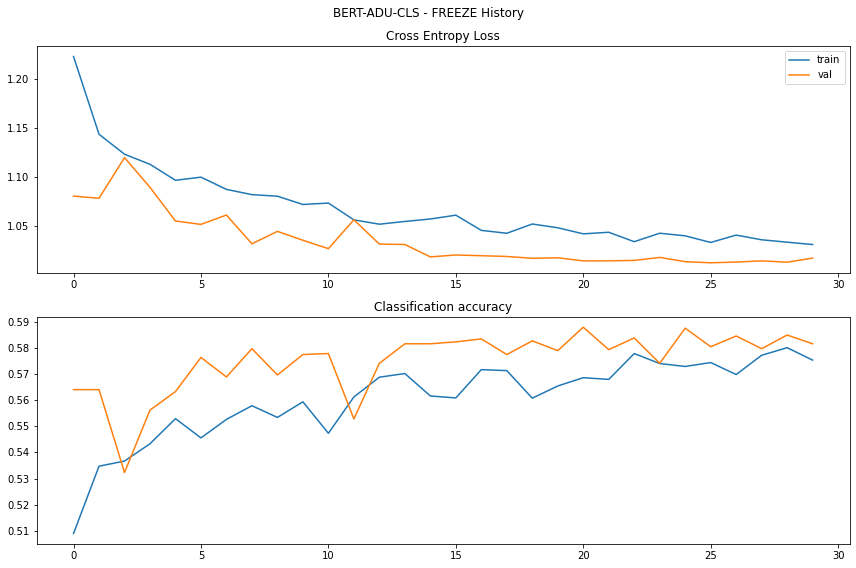

In [22]:
fig = plot_training_history(train_history=train_history, val_history=val_history, model_name="BERT-ADU-CLS", phase_name="FREEZE", out_dir=OUT_DIR)
fig.show()

Clear GPU memory for guarantees

In [20]:
import gc
model = None
train_dataloader = None
val_dataloader = None
lr_scheduler = None
optimizer = None

gc.collect()
torch.cuda.empty_cache()
torch.cuda.mem_get_info("cuda:0")

(13322616832, 15843721216)

In [21]:
!nvidia-smi

Mon Jun  6 05:42:02 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.33.01    Driver Version: 440.33.01    CUDA Version: 11.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla T4            On   | 00000000:00:1E.0 Off |                    0 |
| N/A   53C    P0    27W /  70W |   2404MiB / 15109MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

# Fine-tune model

Load best model from first training session

In [27]:
train_adus

,index,article_id,annotator,node,ranges,tokens,label
0,10106,5cf46103896a7fea06ff85a8,D,1,"[[4120, 4292]]","Erradicar o mal pela raiz, depurando a nação i...",0
1,15332,5cdd9733896a7fea062d6f9f,B,3,"[[533, 671]]",estamos neste momento face a projetos-lei na A...,0
2,14349,5cf45b79896a7fea06ff290a,D,7,"[[1925, 2056]]","são poucos os exemplos, em Portugal, de redes ...",0
3,747,5d04be1c896a7fea06a07c4b,A,31,"[[1841, 1982]]",para quase oito em cada dez portugueses que no...,0
4,2594,5cf478d6896a7fea0600d8ba,A,30,"[[834, 859]]",vitórias na época regular,0
...,...,...,...,...,...,...,...
10711,15909,5ce8e7f4896a7fea06969d15,B,0,"[[77, 111]]",Por uma lei desfasada da realidade,4
10712,262,5d04ad52896a7fea069f9c0d,A,6,"[[1127, 1189]]",este tipo de investimentos prejudicam os clube...,4
10713,3874,5cf47246896a7fea060086ea,D,4,"[[1844, 1954]]",grande aumento dos riscos de doenças tão terrí...,4
10714,5397,5cf46bc3896a7fea0600247f,C,15,"[[5598, 5673]]",a ideia de um “Museu das Descobertas” me pareç...,4


In [34]:
import json
synonyms = {}

with open(DATA_DIR + "/synonyms.json", "r", encoding="utf-8") as synonyms_json:
    synonyms = json.load(synonyms_json)
    
def add_synonyms(article, p = 0.05):
    words = article.split(" ")
    for i in range(len(words)):
        word = words[i]
        if (word in synonyms) and np.random.binomial(1, p):
            words[i] = np.random.choice(synonyms[word])
    return " ".join(words)

# Shift things around to avoid overfit
augmented_train_adus = train_adus.copy()
augmented_train_adus["tokens"] = train_adus["tokens"].apply(add_synonyms, p=0.1)
augmented_train_adus

,index,article_id,annotator,node,ranges,tokens,label
0,10106,5cf46103896a7fea06ff85a8,D,1,"[[4120, 4292]]","Erradicar o mal pela raiz, depurando a nação i...",0
1,15332,5cdd9733896a7fea062d6f9f,B,3,"[[533, 671]]",estamos neste momento rosto a projetos-lei na ...,0
2,14349,5cf45b79896a7fea06ff290a,D,7,"[[1925, 2056]]","são poucos os exemplos, em Portugal, de redes ...",0
3,747,5d04be1c896a7fea06a07c4b,A,31,"[[1841, 1982]]",para quase oito em cada dez portugueses que no...,0
4,2594,5cf478d6896a7fea0600d8ba,A,30,"[[834, 859]]",vitórias na fase regular,0
...,...,...,...,...,...,...,...
10711,15909,5ce8e7f4896a7fea06969d15,B,0,"[[77, 111]]",Por uma lei desfasada da realidade,4
10712,262,5d04ad52896a7fea069f9c0d,A,6,"[[1127, 1189]]",este tipo de investimentos prejudicam os clube...,4
10713,3874,5cf47246896a7fea060086ea,D,4,"[[1844, 1954]]",grande aumento dos riscos de doenças tão terrí...,4
10714,5397,5cf46bc3896a7fea0600247f,C,15,"[[5598, 5673]]",a ideia de um “Museu das Descobertas” me pareç...,4


In [35]:
augmented_train_adus.reset_index(inplace=True)

ft_train_dataset = Dataset.from_pandas(augmented_train_adus, preserve_index=True, info=info)

ft_train_dataset = ft_train_dataset.remove_columns(["annotator", "node", "ranges"])
ft_train_dataset = ft_train_dataset.map(
    tokenize, batched=True, remove_columns=["article_id", "tokens"]
)

print(ft_train_dataset)

  0%|          | 0/11 [00:00<?, ?ba/s]

Dataset({
    features: ['index', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 10716
})


In [37]:
from transformers import DataCollatorWithPadding
from torch.utils.data import DataLoader

BATCH_SIZE = 16 # Tested with NVIDIA Tesla T4 16GB

train_dataloader = DataLoader(
    dataset=ft_train_dataset,
    shuffle=True,
    batch_size=BATCH_SIZE,
    collate_fn=data_collator
)

val_dataloader = DataLoader(
    dataset=cls_dataset["val"],
    shuffle=True,
    batch_size=BATCH_SIZE,
    collate_fn=data_collator
)

In [38]:
model = AutoModelForSequenceClassification.from_pretrained(f"{OUT_DIR}/best", num_labels=N_CLASSES)

print("Loaded best model...")

summary(model)

Loaded best model...


Layer (type:depth-idx)                                  Param #
BertForSequenceClassification                           --
├─BertModel: 1-1                                        --
│    └─BertEmbeddings: 2-1                              --
│    │    └─Embedding: 3-1                              30,509,056
│    │    └─Embedding: 3-2                              524,288
│    │    └─Embedding: 3-3                              2,048
│    │    └─LayerNorm: 3-4                              2,048
│    │    └─Dropout: 3-5                                --
│    └─BertEncoder: 2-2                                 --
│    │    └─ModuleList: 3-6                             302,309,376
│    └─BertPooler: 2-3                                  --
│    │    └─Linear: 3-7                                 1,049,600
│    │    └─Tanh: 3-8                                   --
├─Dropout: 1-2                                          --
├─Linear: 1-3                                           5,125
Total params:

In [39]:
ft_optimizer = optim.Adam(
    params=model.parameters(),
    lr=1e-5,
    betas=(0.9, 0.999),
    weight_decay=5e-4,
    amsgrad=True
)

accelerator = Accelerator()

model, optimizer, train_dataloader, val_dataloader = accelerator.prepare(
    model, optimizer, train_dataloader, val_dataloader
)

ft_lr_scheduler = optim.lr_scheduler.ExponentialLR(
    optimizer=ft_optimizer,
    gamma=0.9,
    verbose=True
)

Adjusting learning rate of group 0 to 1.0000e-05.


In [40]:
ft_train_history = {
    "loss": [],
    "accuracy": []
}

ft_val_history = {
    "loss": [],
    "accuracy": []
}

FT_NUM_EPOCHS = 15
model.bert.requires_grad_(True) # Unfreeze language model layer

ft_best_loss = best_loss 
ft_best_accuracy = best_accuracy
ft_best_epoch = -1

print(f"Starting classification language model fine-tuning...")

for epoch in range(1, FT_NUM_EPOCHS + 1):
    print(f"Epoch[{epoch}/{FT_NUM_EPOCHS}]")
    
    (train_target, train_preds, train_probs, _), train_loss = epoch_iter(
        dataloader=train_dataloader,
        model=model,
        is_train=True,
        optimizer=ft_optimizer,
        lr_scheduler=ft_lr_scheduler
    )
    
    train_accuracy = metric_scorer(torch.tensor(np.array(train_probs)), torch.tensor(np.array(train_target))).item()
    print(f"Training loss: {train_loss:.3f}\t Training micro accuracy: {train_accuracy:.3f}")

    (val_target, val_preds, val_probs, _), val_loss = epoch_iter(
        dataloader=val_dataloader,
        model=model,
        is_train=False,
    )

    val_accuracy = metric_scorer(torch.tensor(np.array(val_probs)), torch.tensor(np.array(val_target))).item()
    print(f"Validation loss: {val_loss:.3f}\t Validation micro accuracy: {val_accuracy:.3f}")
    
    # Save best model
    if val_loss < ft_best_loss:
        ft_best_loss = val_loss
        ft_best_accuracy = val_accuracy
        ft_best_epoch = epoch
        
        accelerator.wait_for_everyone()
        unwrapped_model = accelerator.unwrap_model(model)
        unwrapped_model.save_pretrained(f"{OUT_DIR}/fine_tuned/best", save_function=accelerator.save)

    accelerator.wait_for_everyone()
    unwrapped_model = accelerator.unwrap_model(model)
    unwrapped_model.save_pretrained(f"{OUT_DIR}/fine_tuned/latest", save_function=accelerator.save)

    ft_train_history["loss"].append(train_loss)
    ft_train_history["accuracy"].append(train_accuracy)

    ft_val_history["loss"].append(val_loss)
    ft_val_history["accuracy"].append(val_accuracy)

    print("----------------------------------------------------------------")
    
print(
    f"\nFinished fine-tuning..."
    f"\nBest epoch: {ft_best_epoch}\t Validation loss on best epoch: {ft_best_loss}\t Accuracy on best epoch: {ft_best_accuracy}"
)

Starting classification language model fine-tuning...
Epoch[1/15]


100%|██████████| 670/670 [03:42<00:00,  3.01it/s]


Adjusting learning rate of group 0 to 9.0000e-06.
Training loss: 1.023	 Training micro accuracy: 0.578


100%|██████████| 168/168 [00:10<00:00, 15.81it/s]


Validation loss: 0.943	 Validation micro accuracy: 0.607
----------------------------------------------------------------
Epoch[2/15]


100%|██████████| 670/670 [03:44<00:00,  2.98it/s]


Adjusting learning rate of group 0 to 8.1000e-06.
Training loss: 0.817	 Training micro accuracy: 0.663


100%|██████████| 168/168 [00:10<00:00, 15.87it/s]


Validation loss: 0.944	 Validation micro accuracy: 0.625
----------------------------------------------------------------
Epoch[3/15]


100%|██████████| 670/670 [03:44<00:00,  2.98it/s]


Adjusting learning rate of group 0 to 7.2900e-06.
Training loss: 0.646	 Training micro accuracy: 0.739


100%|██████████| 168/168 [00:10<00:00, 15.89it/s]


Validation loss: 1.041	 Validation micro accuracy: 0.610
----------------------------------------------------------------
Epoch[4/15]


100%|██████████| 670/670 [03:45<00:00,  2.97it/s]


Adjusting learning rate of group 0 to 6.5610e-06.
Training loss: 0.495	 Training micro accuracy: 0.800


100%|██████████| 168/168 [00:10<00:00, 15.98it/s]


Validation loss: 1.254	 Validation micro accuracy: 0.591
----------------------------------------------------------------
Epoch[5/15]


100%|██████████| 670/670 [03:44<00:00,  2.98it/s]


Adjusting learning rate of group 0 to 5.9049e-06.
Training loss: 0.387	 Training micro accuracy: 0.845


100%|██████████| 168/168 [00:10<00:00, 15.93it/s]


Validation loss: 1.375	 Validation micro accuracy: 0.582
----------------------------------------------------------------
Epoch[6/15]


100%|██████████| 670/670 [03:45<00:00,  2.97it/s]


Adjusting learning rate of group 0 to 5.3144e-06.
Training loss: 0.320	 Training micro accuracy: 0.880


100%|██████████| 168/168 [00:10<00:00, 15.77it/s]


Validation loss: 1.548	 Validation micro accuracy: 0.580
----------------------------------------------------------------
Epoch[7/15]


100%|██████████| 670/670 [03:44<00:00,  2.98it/s]


Adjusting learning rate of group 0 to 4.7830e-06.
Training loss: 0.265	 Training micro accuracy: 0.898


100%|██████████| 168/168 [00:10<00:00, 16.04it/s]


Validation loss: 1.660	 Validation micro accuracy: 0.582
----------------------------------------------------------------
Epoch[8/15]


100%|██████████| 670/670 [03:45<00:00,  2.97it/s]


Adjusting learning rate of group 0 to 4.3047e-06.
Training loss: 0.231	 Training micro accuracy: 0.908


100%|██████████| 168/168 [00:10<00:00, 16.04it/s]


Validation loss: 1.691	 Validation micro accuracy: 0.577
----------------------------------------------------------------
Epoch[9/15]


100%|██████████| 670/670 [03:45<00:00,  2.97it/s]


Adjusting learning rate of group 0 to 3.8742e-06.
Training loss: 0.208	 Training micro accuracy: 0.917


100%|██████████| 168/168 [00:10<00:00, 15.76it/s]


Validation loss: 1.794	 Validation micro accuracy: 0.582
----------------------------------------------------------------
Epoch[10/15]


100%|██████████| 670/670 [03:45<00:00,  2.97it/s]


Adjusting learning rate of group 0 to 3.4868e-06.
Training loss: 0.191	 Training micro accuracy: 0.922


100%|██████████| 168/168 [00:10<00:00, 15.86it/s]


Validation loss: 1.848	 Validation micro accuracy: 0.576
----------------------------------------------------------------
Epoch[11/15]


100%|██████████| 670/670 [03:45<00:00,  2.97it/s]


Adjusting learning rate of group 0 to 3.1381e-06.
Training loss: 0.175	 Training micro accuracy: 0.928


100%|██████████| 168/168 [00:10<00:00, 15.99it/s]


Validation loss: 1.935	 Validation micro accuracy: 0.576
----------------------------------------------------------------
Epoch[12/15]


100%|██████████| 670/670 [03:44<00:00,  2.99it/s]


Adjusting learning rate of group 0 to 2.8243e-06.
Training loss: 0.172	 Training micro accuracy: 0.926


100%|██████████| 168/168 [00:10<00:00, 15.75it/s]


Validation loss: 1.993	 Validation micro accuracy: 0.577
----------------------------------------------------------------
Epoch[13/15]


100%|██████████| 670/670 [03:44<00:00,  2.98it/s]


Adjusting learning rate of group 0 to 2.5419e-06.
Training loss: 0.163	 Training micro accuracy: 0.928


100%|██████████| 168/168 [00:10<00:00, 15.88it/s]


Validation loss: 1.985	 Validation micro accuracy: 0.577
----------------------------------------------------------------
Epoch[14/15]


100%|██████████| 670/670 [03:45<00:00,  2.97it/s]


Adjusting learning rate of group 0 to 2.2877e-06.
Training loss: 0.149	 Training micro accuracy: 0.935


100%|██████████| 168/168 [00:10<00:00, 15.79it/s]


Validation loss: 2.054	 Validation micro accuracy: 0.578
----------------------------------------------------------------
Epoch[15/15]


100%|██████████| 670/670 [03:45<00:00,  2.97it/s]


Adjusting learning rate of group 0 to 2.0589e-06.
Training loss: 0.144	 Training micro accuracy: 0.934


100%|██████████| 168/168 [00:10<00:00, 15.64it/s]


Validation loss: 2.104	 Validation micro accuracy: 0.579
----------------------------------------------------------------

Finished fine-tuning...
Best epoch: 1	 Validation loss on best epoch: 0.9432645202392623	 Accuracy on best epoch: 0.6073161363601685


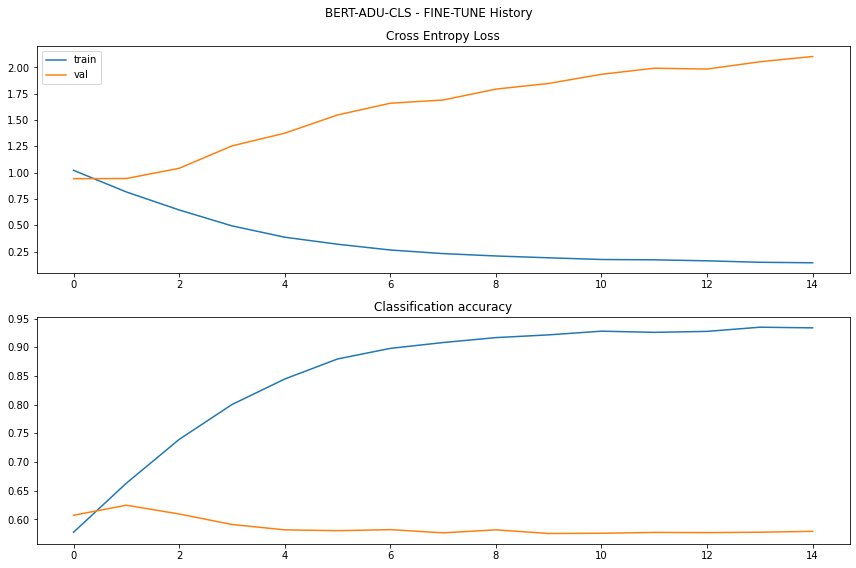

In [42]:
fig = plot_training_history(train_history=ft_train_history, val_history=ft_val_history, model_name="BERT-ADU-CLS", phase_name="FINE-TUNE", out_dir=OUT_DIR)
fig.show()

In [48]:
import gc
model = None

gc.collect()
torch.cuda.empty_cache()
torch.cuda.mem_get_info("cuda:0")

(5116461056, 15843721216)

In [49]:
!nvidia-smi

Mon Jun  6 06:56:10 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.33.01    Driver Version: 440.33.01    CUDA Version: 11.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla T4            On   | 00000000:00:1E.0 Off |                    0 |
| N/A   59C    P0    28W /  70W |  10230MiB / 15109MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

# Test the model

In [50]:
model = AutoModelForSequenceClassification.from_pretrained(f"{OUT_DIR}/fine_tuned/best", num_labels=N_CLASSES)

print("Loaded best fine-tuned model...")

summary(model)

Loaded best fine-tuned model...


Layer (type:depth-idx)                                  Param #
BertForSequenceClassification                           --
├─BertModel: 1-1                                        --
│    └─BertEmbeddings: 2-1                              --
│    │    └─Embedding: 3-1                              30,509,056
│    │    └─Embedding: 3-2                              524,288
│    │    └─Embedding: 3-3                              2,048
│    │    └─LayerNorm: 3-4                              2,048
│    │    └─Dropout: 3-5                                --
│    └─BertEncoder: 2-2                                 --
│    │    └─ModuleList: 3-6                             302,309,376
│    └─BertPooler: 2-3                                  --
│    │    └─Linear: 3-7                                 1,049,600
│    │    └─Tanh: 3-8                                   --
├─Dropout: 1-2                                          --
├─Linear: 1-3                                           5,125
Total params:

In [51]:
accelerator = Accelerator()

model, test_dataloader = accelerator.prepare(model, test_dataloader)

In [52]:
(test_target, test_preds, test_probs, test_ids), test_loss = epoch_iter(
    dataloader=test_dataloader,
    model=model,
    is_train=False,
)

100%|██████████| 3348/3348 [01:14<00:00, 45.15it/s]


In [55]:
from sklearn.metrics import classification_report
print(classification_report(y_true=test_target, y_pred=test_preds, target_names=le.classes_.tolist()))

              precision    recall  f1-score   support

        Fact       0.54      0.58      0.56       733
      Policy       0.59      0.52      0.55       133
       Value       0.62      0.74      0.68      1620
    Value(+)       0.61      0.36      0.46       282
    Value(-)       0.68      0.41      0.51       580

    accuracy                           0.61      3348
   macro avg       0.61      0.52      0.55      3348
weighted avg       0.61      0.61      0.60      3348



In [62]:
def getErrors(adu_dataframe, adu_ids, y_true, y_pred):
    df = pd.DataFrame(columns=["id", "adu", "target", "predicted"])
    for (aduId, correct, predicted) in zip(adu_ids, y_true, y_pred):
        if correct == predicted:
            continue
        row = {
            "id": aduId,
            "adu": adu_dataframe.iloc[aduId]["tokens"],
            "target": correct,
            "predicted": predicted
        }
        
        df = df.append(row, ignore_index=True)
    return df

errors_df = getErrors(adus, test_ids, le.inverse_transform(test_target), le.inverse_transform(test_preds))
errors_df

,id,adu,target,predicted
0,45,O problema é que são infinitamente minoritários,Fact,Value
1,82,ainda há guerras aqui e ali,Fact,Value
2,83,"as ""grandes"" guerras do século XX parece difíc...",Value(+),Value
3,86,bem sabemos como a falta de controle das compe...,Value(-),Value
4,100,com a vantagem de essas guerras serem organiza...,Fact,Value
...,...,...,...,...
1304,16688,os exames efetuados com sucesso e as suas clas...,Value,Fact
1305,16689,As restrições orçamentais,Value,Fact
1306,16713,A única variável disponibilizada que pode ser ...,Fact,Value
1307,16723,"dentro dessas limitações, cada jovem é confron...",Fact,Value


In [63]:
errors_df.to_csv(f"{OUT_DIR}/test_errors.csv", index=False)